In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.signal import correlate2d

In [ ]:
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

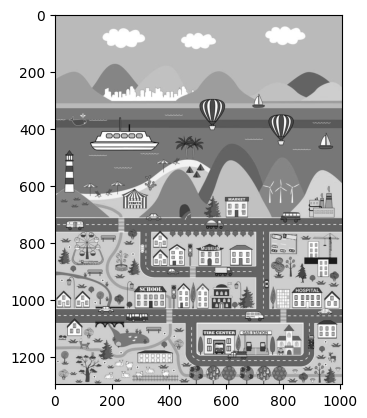

In [3]:
image = cv2.imread('map.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, 'gray')
plt.show()

In [4]:
baloon = image[297:407,507:597]
nbaloon = normalize(baloon)
nimage = normalize(cv2.equalizeHist(image))

In [5]:
corr_map = correlate2d(nimage, nbaloon)

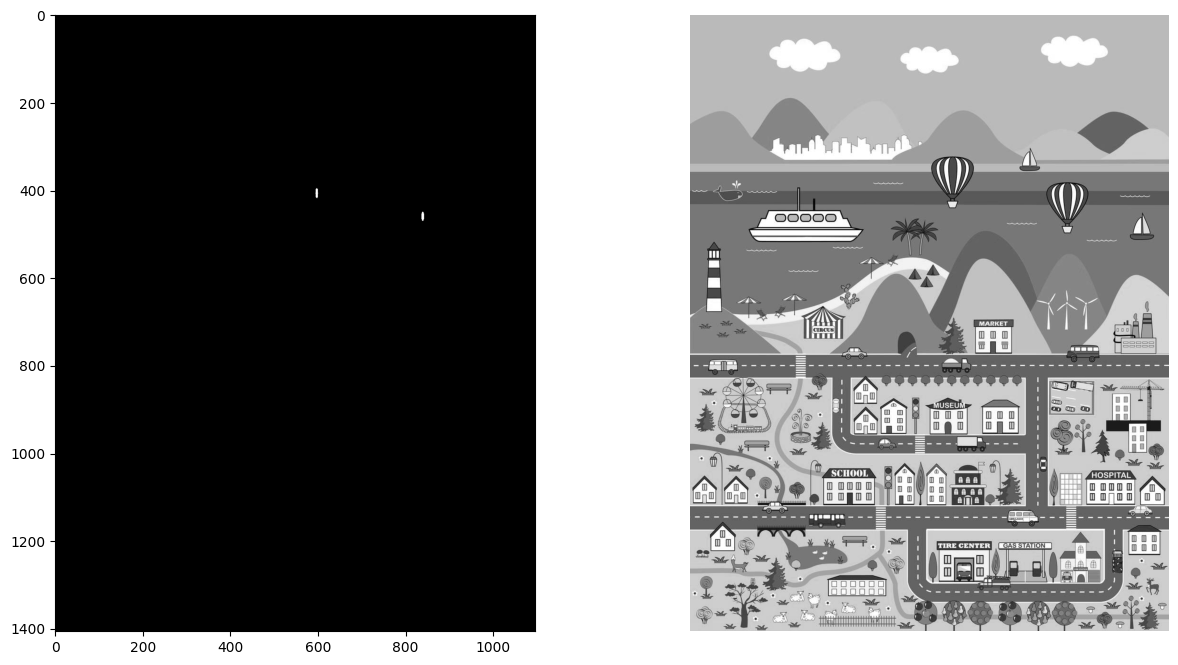

In [6]:
res = (corr_map >= 3000).astype(np.uint8)
_, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.imshow(res, 'gray', vmin=0, vmax=1)
ax2.axis('off')
ax2.imshow(image , 'gray')
plt.show()